#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
hak=1 # moment of area vs moment of inertia; has proportionality coefficient

In [11]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho_=hak*np.diag(diag_Irho)

In [12]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [13]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [14]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [15]:
vessel_inertia

60751987031.24999

In [16]:
def Jv(X,Y,Z,i):
    
    l=[]
    for j in range(1,len(X)):
        l.append(math.sqrt((X[j]-X[j-1])**2+(Y[j]-Y[j-1])**2+(Z[j]-Z[j-1])**2))
    
    
    
    def Jv0(i, k, l):

        if k<i:
            tmp1=np.dot(l[k:i],[((X[p]-X[p-1]))/l[p-1] for p in range(k+1,i,1)])
            tmp1+=0.5*l[len(X)-2]*(X[len(X)-1]-X[len(X)-1-1])/l[len(X)-2]

            tmp2=np.dot(l[k:i],[((Y[p]-Y[p-1]))/l[p-1] for p in range(k+1,i,1)])
            tmp2+=0.5*l[len(Y)-2]*(Y[len(Y)-1]-Y[len(Y)-1-1])/l[len(Y)-2]

            tmp3=np.dot(l[k:i],[((Z[p]-Z[p-1]))/l[p-1] for p in range(k+1,i,1)])
            tmp3+=0.5*l[len(Z)-2]*(Z[len(Z)-1]-Z[len(Z)-1-1])/l[len(Z)-2]
            
            return np.array([tmp1, tmp2, tmp3]).T
        elif i==k:
            return np.array([0.5*l[i]*(X[i]-X[i-1])/l[i],0.5*l[i]*(Y[i]-Y[i-1])/l[i],0.5*l[i]*(Z[i]-Z[i-1])/l[i]]).T
        else:
            return np.array([0, 0, 0]).T 
        
    ans=np.array([Jv0(i, k,  l) for k in range(len(X))])    
                
    return ans
           

In [143]:
def inert(M, m, X):

    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(sum_.copy())

    return np.array(ans[::-1])

In [18]:
# def inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws):
#     V_rho=np.zeros(Irho_.shape)
#     np.fill_diagonal(V_rho, vessel_inertia)
#     cum_m=0
#     cum_i=0
#     fin_123=[]
#     for i in range(node_N-1,-1,-1):
#         cum_m+=Ws[i]*cum_d_inv[i]**2
#         cum_i+=Irho_
#         fin_123.append(V_rho+cum_m + cum_i)
#     return np.array(fin_123[::-1])

In [19]:
lll = [100 for i in range(node_N)]

In [20]:
cum_d_inv=[10]
sum_=0
for i in range(len(lll)-1,-1,-1):
    sum_+=lll[i]
    cum_d_inv.append(sum_)
cum_d_inv=cum_d_inv[::-1]    

In [21]:
# cum_d_inv

In [22]:
Ws = np.array(mi)*9.81

In [23]:
# Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
# Irho=np.array(fin_123)

In [24]:
# Irho

In [25]:
# Irho+=vessel_inertia

In [26]:
# Irho[-1][0][0]

In [27]:
# Irho[-49][0][0]

In [28]:
# Irho

In [29]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [30]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [31]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [32]:
E = 210e9

In [33]:
E*Ar/1e10

1.6991625880187402

In [34]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [35]:
DT=np.diag(diag_DT) # (35) in [2]

In [36]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [37]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [38]:
CT=np.diag(diag_CT)

In [39]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [40]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [41]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [42]:
rng = np.random.default_rng()

In [43]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [44]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [45]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.53555927, -0.84013747, -0.08570472],
       [-0.35368056, -0.1309803 , -0.92615022],
       [ 0.76686787,  0.52632043, -0.367288  ]])

In [46]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.009281


In [47]:
Ret.shape

(50, 3, 3)

In [48]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [49]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float32)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float32)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float32))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float32)),axes = 0)
    return np.array(ans).T

In [50]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000531


In [51]:
C1(dx,dy,dz,Ret)

array([[ 6.28550649e-02, -1.21266794e+00, -1.06278479e+00,
         5.19647822e-02,  1.09145381e-01,  6.27881646e-01,
        -4.52393815e-02, -4.54656076e+00,  1.03117771e-01,
        -1.78251731e+00, -2.35176459e-01,  2.25469042e-02,
         2.20507180e-04,  7.85404742e-01, -2.02297255e-01,
        -7.64115453e-01,  8.75441849e-01,  1.78412348e-02,
        -1.19750999e-01,  2.35023931e-01, -1.17123937e-02,
         5.07631481e-01,  5.41068733e-01,  1.13680765e-01,
        -7.52595291e-02, -1.30162969e-01, -4.55306888e-01,
         7.24342883e-01,  1.73353210e-01, -4.73263741e+00,
        -9.23536479e-01, -1.27719879e+00, -1.20073426e+00,
         2.88966328e-01,  4.10529566e+00, -2.43505582e-01,
         1.29702926e-01, -1.19634502e-01, -2.63821459e+00,
        -2.20985450e-02, -1.20842159e-01,  1.04471898e+00,
         5.50084472e-01,  1.85396944e-04, -3.11219133e-02,
         9.83476818e-01,  1.36530949e-02,  5.55202737e-02,
         3.05304766e-01,  1.26064217e+00],
       [-1.23

In [52]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [53]:
fD(dx,dy,dz,DT,Ret).T

array([[ 3.60727350e+02, -7.07005919e+02, -4.53975232e+02],
       [-6.95954247e+03, -7.67670826e+03,  1.37456279e+04],
       [-6.09935798e+03,  3.71921606e+02, -1.83177876e+04],
       [ 2.98227648e+02,  1.37287268e+04, -1.23633036e+03],
       [ 6.26389043e+02, -5.25952582e+02,  7.61488796e+02],
       [ 3.60343408e+03,  2.65777647e+04,  2.25931045e+04],
       [-2.59630346e+02,  2.33215899e+03,  1.29846554e+03],
       [-2.60928665e+04,  3.50217730e+04, -1.65647671e+04],
       [ 5.91796390e+02, -8.93286560e+03, -8.75416321e+03],
       [-1.02299274e+04,  2.35012980e+03,  1.03090838e+03],
       [-1.34968568e+03,  4.34974244e+03,  5.36064262e+03],
       [ 1.29397448e+02,  8.76088323e+02, -3.10275813e+03],
       [ 1.26549819e+00, -2.19155440e+04, -3.60832996e+04],
       [ 4.50746447e+03,  1.12825711e+04, -1.15358249e+04],
       [-1.16099081e+03,  1.54624660e+03, -1.95989060e+03],
       [-4.38528452e+03,  1.64575480e+03, -8.36272898e+03],
       [ 5.02419048e+03, -6.14156980e+03

In [54]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000668


In [55]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [56]:
I=np.identity(3)

In [57]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000295


In [58]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [59]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [60]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [61]:
DR=np.diag(diag_DR) 

In [62]:
Ar

0.08091250419136858

In [63]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [64]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [65]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [66]:
def Re_b(Ret):
    return Ret

In [67]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000074


In [68]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float32),B.T.astype(np.float32))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [69]:
phi(x,y,z,Ret,None,None)

array([[ 1.4094636 , -0.9540321 ,  0.5044859 ],
       [ 0.7054344 ,  0.29975495,  0.47646603],
       [-2.6813242 ,  1.8960992 ,  0.55290467],
       [ 1.3860567 , -1.6033365 ,  1.3897418 ],
       [ 0.7572302 ,  0.47277278, -0.43251577],
       [-2.1586914 , -2.8309345 ,  0.643933  ],
       [-0.11734577, -0.1255364 ,  1.1818081 ],
       [ 1.1983285 ,  0.53613675, -0.8137927 ],
       [ 1.183144  ,  0.62062   , -0.7360849 ],
       [ 1.5964576 ,  0.47568655, -0.69755024],
       [-1.3964218 ,  0.46209204, -0.181772  ],
       [-0.20544039, -0.10008788, -0.31180862],
       [ 0.18017988, -1.5277628 ,  0.35026622],
       [ 0.48978472,  0.55960274,  0.25209206],
       [-0.7959504 , -0.8600311 , -0.37048846],
       [-1.4415973 , -0.22669555, -1.0468928 ],
       [ 0.60885376,  0.07528081,  1.2893212 ],
       [ 1.4231294 , -1.059905  , -0.3161092 ],
       [-0.68551016,  0.15096962, -0.3225494 ],
       [ 1.0513045 , -1.0571897 ,  0.17355514],
       [-0.27903587,  0.29462188,  1.305

In [70]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000243


In [71]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [72]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [73]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.001716


In [74]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [75]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.001613


In [76]:
ωe(φ,θ,ψ,None,None,None)

array([[-1.89125285e+00, -1.67779984e-01,  4.24473538e-01],
       [ 1.80208020e+00, -8.97068720e-01, -8.91493757e-01],
       [-6.89045481e-01, -7.52513909e-01, -6.80956450e-01],
       [-7.43851784e-01, -9.74269301e-01, -7.60306269e-01],
       [ 3.58835971e-01,  2.17880633e+00, -1.48328390e+00],
       [-2.71307383e-01, -6.40840401e-01, -3.24969754e-01],
       [-9.31063622e-01, -8.17909218e-02,  1.60306150e+00],
       [ 3.39755324e-01, -4.16616471e-01, -6.13160286e-01],
       [ 4.26731715e-01,  7.93121115e-02, -8.55247484e-01],
       [-4.77559839e-03,  8.14843419e-01,  9.47214891e-01],
       [ 1.16601384e+00,  3.92778452e-01,  5.45229770e-01],
       [-1.28151141e+00,  2.68601465e+00,  5.17395163e-01],
       [ 2.30061057e-01, -6.97006536e-01, -1.01706204e+00],
       [-8.53064534e-01, -4.96676057e-01, -5.31724281e-01],
       [-2.79292300e-01,  5.21817276e-02,  8.07799568e-01],
       [-1.72138748e+00,  6.68430743e-01,  3.67271485e-01],
       [-1.58884280e+00,  3.63294999e+00

In [77]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
#     if flag==1:
#         fun+=-np.dot(Ret,force)
# #         fun*=-np.dot(Ret,force)
#     elif flag==2:
#         fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [78]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [79]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 1.30793817e-02,  1.60631282e-03, -1.19921918e-02,
         2.68591475e-02, -8.12447096e-03,  3.11320896e-02,
         1.17617371e-02, -1.21236781e-02, -1.21802664e-02,
        -1.05362996e-02, -5.77177143e-03, -1.91105435e-03,
         1.68257849e-02, -2.73895014e-03,  4.36188740e-03,
        -7.39495302e-03,  1.09323080e-02,  6.64017506e-03,
        -4.25459367e-03,  1.10236686e-02,  9.11720577e-03,
        -2.06798300e-02,  2.78785619e-03,  9.01699084e-03,
         7.90978628e-03,  8.12987904e-03, -9.71195739e-03,
         5.15579012e-03,  1.48549538e-04,  1.38767920e-03,
         2.16046709e-03,  4.05148144e-03, -1.08606255e-02,
        -7.89283688e-03, -1.70549268e-02, -1.58682852e-02,
         1.12222496e-02, -1.14891028e-03,  1.96502009e-02,
         1.03735786e-03,  1.20575635e-02,  1.89256265e-02,
        -3.91169061e-03,  5.73550426e-03, -1.24144767e-03,
         1.05628658e-02,  6.18565722e-03,  2.29376609e-02,
         1.44845897e-02,  1.31513290e-02],
       [-3.78

In [80]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.003158


In [81]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [82]:
# np.dot(Ret.astype(np.float32)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [83]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze()

In [84]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [85]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-8.31029203e-07,  1.20795765e-06, -3.86471880e-07,
        -7.52006647e-07, -1.14185992e-06, -5.57601687e-07,
        -7.89868002e-07,  5.86813175e-07,  1.03498842e-07,
        -1.63861664e-06, -4.20903670e-07, -4.80179806e-08,
        -1.36743733e-07, -9.54988132e-07,  1.26545225e-06,
        -3.76196168e-07,  5.86772233e-07,  1.65754021e-06,
        -1.02667526e-06,  2.45100337e-06,  1.68813722e-06,
        -1.07459644e-06, -4.16637460e-07, -1.10443472e-06,
        -2.28168804e-06,  3.92642460e-07,  1.25885371e-06,
        -9.60829760e-07, -9.97154701e-08, -6.21162558e-07,
         2.05491332e-06,  3.28020094e-07, -1.15040192e-06,
        -1.06871596e-06,  4.66331852e-06, -2.01508962e-07,
         9.34267824e-07, -2.46376184e-07,  1.42006369e-06,
         1.92316093e-07,  2.32550864e-06, -1.98543597e-06,
         1.56329490e-06,  4.23048424e-07, -2.92350666e-07,
         1.56934815e-06,  1.11197805e-06, -6.81595829e-07,
         6.05194921e-07, -2.68472356e-06],
       [ 7.38

In [86]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [87]:
ne_(dx,dy,dz,DT,Ret)

array([[-3.60727350e+02,  6.95954247e+03,  6.09935798e+03,
        -2.98227648e+02, -6.26389043e+02, -3.60343408e+03,
         2.59630346e+02,  2.60928665e+04, -5.91796390e+02,
         1.02299274e+04,  1.34968568e+03, -1.29397448e+02,
        -1.26549819e+00, -4.50746447e+03,  1.16099081e+03,
         4.38528452e+03, -5.02419048e+03, -1.02391452e+02,
         6.87255047e+02, -1.34881031e+03,  6.72178251e+01,
        -2.91331430e+03, -3.10521182e+03, -6.52417769e+02,
         4.31916991e+02,  7.47009698e+02,  2.61302168e+03,
        -4.15702839e+03, -9.94879956e+02,  2.71607667e+04,
         5.30020720e+03,  7.32988721e+03,  6.89105465e+03,
        -1.65838756e+03, -2.35604311e+04,  1.39748680e+03,
        -7.44369492e+02,  6.86586465e+02,  1.51408031e+04,
         1.26824300e+02,  6.93517250e+02, -5.99567769e+03,
        -3.15695345e+03, -1.06399936e+00,  1.78609717e+02,
        -5.64420683e+03, -7.83555749e+01, -3.18632735e+02,
        -1.75215441e+03, -7.23486820e+03],
       [ 7.07

In [88]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.004130


In [89]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-1.29972672e+02,  3.69419006e+06, -2.38145571e+06],
       [-1.83501260e+03,  1.75153310e+07,  1.02019797e+06],
       [-6.73079908e+03,  4.81130768e+07,  1.98757870e+07],
       [-5.56042157e+03,  4.47492150e+07,  1.14172274e+07],
       [ 1.36683234e+00, -1.62710766e+04,  2.46481684e+03],
       [-7.67545778e+03,  6.16539259e+07,  1.58767406e+07],
       [ 2.98095549e+01,  4.29440920e+05, -7.30584499e+05],
       [-1.05072772e+04,  4.14391783e+07,  6.46981934e+07],
       [-2.35999001e+03, -1.82924282e+07,  4.21328417e+07],
       [ 1.00254603e+04, -6.41541219e+07, -3.71150157e+07],
       [ 4.45716380e+02, -4.81105067e+06,  3.08881511e+05],
       [-7.25079773e+02,  4.22699559e+06,  3.09719809e+06],
       [-8.72659787e+03,  5.42384790e+07,  3.39106760e+07],
       [-9.01292880e+02,  1.43702302e+07, -5.26653031e+06],
       [ 6.17707906e+03, -9.89180697e+06, -5.25055799e+07],
       [ 2.95555642e+02, -3.42029739e+06,  4.34909463e+05],
       [-4.39901148e+03,  5.91047165e+07

In [90]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-1.59235153e+10, -2.39722004e+08, -3.70995362e+08],
       [-2.61138806e+09,  1.01761272e+08, -1.75179165e+09],
       [-3.75019946e+09,  1.98720747e+09, -4.81167904e+09],
       [-1.53773114e+09,  1.14157053e+09, -4.47507383e+09],
       [ 3.16838437e+09,  5.60151800e+05,  1.94076192e+06],
       [-8.56625311e+09,  1.58682604e+09, -6.16624074e+09],
       [-1.55183704e+10, -7.45947705e+07, -4.44803341e+07],
       [-5.86817831e+09,  6.46923853e+09, -4.14449884e+09],
       [-3.85390066e+09,  4.21290273e+09,  1.82886135e+09],
       [-1.10452767e+09, -3.71161100e+09,  6.41530299e+09],
       [-8.91892568e+09,  3.00051780e+07,  4.80222148e+08],
       [ 7.71136581e+08,  3.09796158e+08, -4.22623229e+08],
       [-8.14386869e+08,  3.39098705e+09, -5.42392864e+09],
       [-1.13630564e+10, -5.27777986e+08, -1.43814794e+09],
       [-5.17084365e+09, -5.25107002e+09,  9.88668831e+08],
       [-8.12973262e+09,  4.26861036e+07,  3.41224944e+08],
       [-3.60620393e+07, -1.46710449e+09

In [91]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000768


In [92]:
Re_b(Ret).shape

(50, 3, 3)

In [93]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret,Irho): # here
#     ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     print(Irho[1])
#     print(np.dot(np.dot(Ret[1],Irho[1]),Ret[1]))
#     ans=  np.einsum('ijk,ikp->ijp', np.einsum('i,ikp->ikp', Irho, Ret),Ret)
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [94]:
# Irho_e(Ret,Irho)

In [95]:
# startTime1 = datetime.now()
# Irho_e(Ret,Irho)
# print(datetime.now() - startTime1)

In [96]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [97]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [98]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [99]:
def d_me(φ,θ,ψ,Ret,omega):
    
    def f(a,b,c,Ret,omega, dummy2): 
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float32)).squeeze()
   
    B=d_s(f,φ,θ,ψ,Ret.astype(np.float32),omega.astype(np.float32))

    return B.T.astype(np.float32)

In [100]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.002023


In [101]:
d_me_

array([[ 4.53683424e-05,  3.30232353e+01, -3.34832001e+01],
       [ 4.61582822e-04,  6.01585817e+00, -1.06788521e+01],
       [ 8.50205601e-04, -3.80116129e+00, -4.78701496e+00],
       [ 7.39105511e-04, -5.39155102e+00, -2.07426429e+00],
       [-2.77377353e-06,  1.29146328e+01, -1.28872690e+01],
       [-9.67157772e-04,  1.98780715e+00,  7.78185558e+00],
       [ 2.92832574e-05,  3.62235756e+01, -3.65212212e+01],
       [ 8.97217018e-04, -1.26868410e+01,  3.62422895e+00],
       [ 2.30161799e-03, -2.09195824e+01, -2.32919884e+00],
       [ 1.51472201e-03, -2.07668457e+01,  5.46690416e+00],
       [ 2.33167259e-04,  2.32280102e+01, -2.55845337e+01],
       [ 1.14723202e-03, -7.32426500e+00, -4.26415014e+00],
       [ 2.06411444e-03, -2.50623760e+01,  4.21295500e+00],
       [-3.91808222e-04,  2.31068630e+01, -1.91501770e+01],
       [ 2.08397023e-03, -1.98252525e+01, -1.22501040e+00],
       [ 1.41056325e-05,  2.29257851e+01, -2.30694370e+01],
       [ 1.97022175e-03, -2.34033108e+01

In [102]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [103]:
ne_(dx,dy,dz,DT,Ret)

array([[-3.60727350e+02,  6.95954247e+03,  6.09935798e+03,
        -2.98227648e+02, -6.26389043e+02, -3.60343408e+03,
         2.59630346e+02,  2.60928665e+04, -5.91796390e+02,
         1.02299274e+04,  1.34968568e+03, -1.29397448e+02,
        -1.26549819e+00, -4.50746447e+03,  1.16099081e+03,
         4.38528452e+03, -5.02419048e+03, -1.02391452e+02,
         6.87255047e+02, -1.34881031e+03,  6.72178251e+01,
        -2.91331430e+03, -3.10521182e+03, -6.52417769e+02,
         4.31916991e+02,  7.47009698e+02,  2.61302168e+03,
        -4.15702839e+03, -9.94879956e+02,  2.71607667e+04,
         5.30020720e+03,  7.32988721e+03,  6.89105465e+03,
        -1.65838756e+03, -2.35604311e+04,  1.39748680e+03,
        -7.44369492e+02,  6.86586465e+02,  1.51408031e+04,
         1.26824300e+02,  6.93517250e+02, -5.99567769e+03,
        -3.15695345e+03, -1.06399936e+00,  1.78609717e+02,
        -5.64420683e+03, -7.83555749e+01, -3.18632735e+02,
        -1.75215441e+03, -7.23486820e+03],
       [ 7.07

### Static solution

In [104]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [105]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [106]:
Fx_0=82945396

In [107]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [108]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [109]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [110]:
delta_x=horizontal_length/(node_N-1)

In [111]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [112]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [113]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

In [114]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [115]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

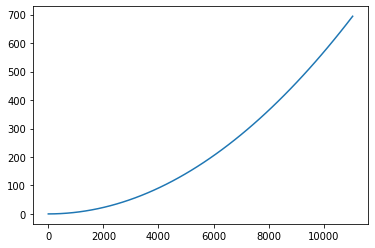

In [116]:
plt.plot(x0, z0)
plt.show()

In [117]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [118]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [119]:
V_rho

array([[6.0751987e+10, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 6.0751987e+10, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 6.0751987e+10]])

In [120]:
Jv(x0,[0 for i in range(len(z0))],z0,len(z0))

array([[11165.46734287,     0.        ,   708.46681953],
       [10939.90234605,     0.        ,   708.17797669],
       [10714.33734922,     0.        ,   707.31144627],
       [10488.7723524 ,     0.        ,   705.86722258],
       [10263.20735557,     0.        ,   703.84529616],
       [10037.64235875,     0.        ,   701.24565373],
       [ 9812.07736192,     0.        ,   698.06827826],
       [ 9586.51236509,     0.        ,   694.3131489 ],
       [ 9360.94736827,     0.        ,   689.98024102],
       [ 9135.38237144,     0.        ,   685.0695262 ],
       [ 8909.81737462,     0.        ,   679.58097223],
       [ 8684.25237779,     0.        ,   673.51454311],
       [ 8458.68738097,     0.        ,   666.87019906],
       [ 8233.12238414,     0.        ,   659.64789648],
       [ 8007.55738731,     0.        ,   651.84758802],
       [ 7781.99239049,     0.        ,   643.4692225 ],
       [ 7556.42739366,     0.        ,   634.51274497],
       [ 7330.86239684,     0. 

In [121]:
# def Joma(J):
#     return (J/(J.max(axis=0)+1e-6))[::-1]

In [141]:
def Joma_I(I):
    ans=[]
    for i in range(len(I)):
#         print(I[-1].diagonal()[0]/I[i].diagonal()[0])
        ans.append(I[-1].diagonal()/I[i].diagonal())
    return np.array(ans)

In [144]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

AttributeError: 'float' object has no attribute 'copy'

In [139]:
Irho

array([[[6.0752012e+10, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 6.0752012e+10, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 6.0752037e+10]],

       [[6.0752012e+10, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 6.0752012e+10, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 6.0752037e+10]],

       [[6.0752012e+10, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 6.0752012e+10, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 6.0752037e+10]],

       [[6.0752012e+10, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 6.0752012e+10, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 6.0752037e+10]],

       [[6.0752012e+10, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 6.0752012e+10, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 6.0752037e+10]],

       [[6.0752012e+10, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 6.0752012e+10, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 6.0752037e+10]],

In [137]:
Joma_I(Irho)

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1

In [ ]:
def Joma_M(I):
    ans=[]
    for i in range(len(I)):
        ans.append(I[-1]/I[i])
    return np.array(ans)

In [ ]:
Joma_M(inert(vessel_mass*9.81,mp*9.81, x0))

In [ ]:
# def mass(M, m, X,Y,Z):
  
#     M1=Jv(X,Y,Z,len(X))**2*M
# #     print(M1.shape)
# #     print((Jv(X,Y,Z,len(X))**2).shape)
#     M2=Jv(X,Y,Z,len(X))**2*m
    
#     return np.sum(M1+M2,axis=1)

In [ ]:
inert(vessel_mass*9.81,mp*9.81, x0).shape

In [ ]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
    elif j==7:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.00010522890316932987*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([6.952842745988619e-09*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([0.00010649100253301569*(i+1)/node_N*init for i in range(node_N)])
#        q0[(j-1)*node_N]=0 
# q0[7*node_N-1]= -0.00010522890316932987 # here
# q0[9*node_N-1]= 6.952842745988619e-09
# q0[11*node_N-1]=0.00010649100253301569 # here

In [ ]:
Irho[-1]-Irho[-2]

In [ ]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
#     Z0=-np.dot(Re_b(Ret),tau_force[:3])
    
    Z0= - np.einsum('ijk,i->ij', Re_b(Ret), np.dot(Joma(Jv(x,y,z,len(z))), tau_force[:3].reshape(3,1)).squeeze())
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
#     print(M_t)
    
############################################################ 
#     print(Re_b(Ret).shape,M_t.shape)
#     ddx,ddy, ddz = np.linalg.solve(np.einsum('ijk,ik->ij',Re_b(Ret),M_t),Z).T
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 

#     sum_0123=0
#     lll=[]
#     for i in range(1,len(z0)):
#         sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
#         lll.append(sum_0123)
        
#     cum_d_inv=[0]
#     sum_=0
#     for i in range(len(lll)-1,-1,-1):
#         sum_+=lll[i]
#         cum_d_inv.append(sum_)
#     cum_d_inv=cum_d_inv[::-1] 
     
    
#     Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
    
    
    
    C0=-np.einsum('ijk,i->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)), np.dot(Joma(Jv(x,y,z,len(z))),tau_force[:3].reshape(3,1)).squeeze()) 
    
    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [ ]:
q0

In [ ]:
root = fsolve(static_func, q0)

In [ ]:
root

In [ ]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [ ]:
q0=root

In [ ]:
q0

In [ ]:
# x0_

In [ ]:
# z0

In [ ]:
# z0_

In [ ]:
plt.plot(x0_, z0_)
plt.show()

In [ ]:
# init=1
# for j in range(1,12):
#     if j==1:  
#         q0[(j-1)*node_N:j*node_N]=x0_
#     elif j==5:    
#         q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
# #         q0[(j-1)*node_N]=0
#     elif j==7:    
#         q0[(j-1)*node_N:j*node_N]=np.array([-0.00010522890316932987*(i+1)/node_N*init for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=np.array([6.952842745988619e-09*(i+1)/node_N*init for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=np.array([0.00010649100253301569*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0 
# # q0[9*node_N-1]=0.13  # here
# q0[7*node_N-1]= -0.00010522890316932987 # here
# q0[9*node_N-1]= 6.952842745988619e-09
# q0[11*node_N-1]=0.00010649100253301569  # here

### Vessle Simulation

In [ ]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [ ]:
vehicle=semisub('DPcontrol',0,5,40.0,0,0) 

In [ ]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [ ]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

In [ ]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [ ]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

In [ ]:
plotVehicleStates(simTime, simData, 3)

In [ ]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [ ]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
# Ws[0]*Ret[2]

In [ ]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

In [ ]:
idx=1/0.01

In [ ]:
idx

In [ ]:
ssa(simData[:, 3][int(idx)])

In [ ]:
ssa(simData[:, 4][int(idx)])

In [ ]:
ssa(simData[:, 5][int(idx)])

### Dynamics

In [ ]:
def grayscott1d(t, Q): # here
    print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t+1) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    φ=ssa(φ)
    θ=ssa(θ)
    ψ=ssa(ψ)
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
    force_schedule=1
#     force_schedule=1
#     force_schedule=0
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     print(tau_force)
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)

    
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1]   

#     print(np.dot(1/(Jv(x,y,z,len(z))+1e-3),tau_force[:3].reshape(3,1)).squeeze())
#     print(tau_force[:3])
#     Z0=-np.einsum('ijk,ik->ij', Re_b(Ret), np.einsum('i,k->ik',cum_d_inv[::-1],tau_force[:3])/max(cum_d_inv))
    Z0= - np.einsum('ijk,i->ij', Re_b(Ret), np.dot(Joma(Jv(x,y,z,len(z))),tau_force[:3].reshape(3,1)).squeeze())

#     Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     Z0=-tau_force[:3]
#     print(Ret)
#     print(Z0.shape)
#     print(Z0)
    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)
  
    Z= (
        Z1
        + Z2 
        +Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    
#     print(Ws)
    RRRR=Re_b(Ret)
#     print(Ret)
    haka=1
    
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T
#     ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
    
    
#     ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
# #                                              [Ws[i] for i in range(node_N)]
# #                                              +[Ws[-1] + vessel_mass]
#                                              haka*M_totl
                                          
#                                              ,RRRR),
#                                    Z
#                                   ).T 
# #     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      


#     print(cum_d_inv[0])
#     Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
#     print(Irho[12])
#     print()
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float32),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
#     print(C3)
    
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, 
#                  ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     print(C4)
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

#     C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C0=-np.einsum('ijk,i->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)), np.dot(Joma(Jv(x,y,z,len(z))),tau_force[:3].reshape(3,1)).squeeze())
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
#     print(C0,C1,C2,C3,C4)



#     print(B)   
    
#     print(Irho_e(Ret,Irho))
#     A2 = Irho_e(Ret,Irho).astype(np.float32)
#     A3=Π(φ,θ,ψ).astype(np.float32)

#     A=np.einsum('ijk,ikr->ijr',A2,A3)
    A2 = Irho_e(Ret,Irho).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

#     hack=1e18
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################
#     print(B[49])
#     print()

#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111[-1])
    return A1111

In [ ]:
# import scipy

In [ ]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [ ]:
# us=ode15s.integrate(10)

In [ ]:
tspan = (0., 0.12)

In [ ]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

In [ ]:
# key takeaway: one can calibrate the model by tuning the hack, bc(init), force_schedule, hak and haka

# the main problem of the model is that it accelirates too much
# the hack increases the mass, the greater the mass the lesser the  acceleration
# the force_schedule affects the force, the lesser the force the lesser the  acceleration
# bc set conditions on how much force from the vessel should be applied to counteract the movement because of bc

# too fast acceleration leads to solution divergence in short amount of time

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()